In [ ]:
!pip install requests
!pip install pycbrf
!pip install plotly

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

import requests
import json

import re
from pycbrf.toolbox import ExchangeRates

Пайплайн:   
1) Делаем запрос к API Head Hunter, чтобы собрать данные по вакансиям  
2) EDA  
3) Feature engineering  
- тип работы (или направление: DS, MLE или DS/MLE)
- грейд (Intern, Junior, Moddle, Senior, Lead)
- наличие информации о з/п

## 1.Сбор данных

In [ ]:
# Задаем параметры для запроса

url = 'https://api.hh.ru/vacancies'

params= {"text": "NAME:(Data scientist OR Data Science OR ML Engineer OR Machine Learning Engineer OR MLops OR ML Аналитик)",
         "per_page": 100,
         "page": 0,
         "area": 1, # Москва
         "period": 30 # Вакансии за последние 30 дней
         }

headers={"User-Agent": "HH-User-Agent"}

In [ ]:
# Делаем запрос

answer = requests.get(url=url, params=params, headers=headers)
answer.status_code

200

In [ ]:
json_text = json.loads(answer.text)

In [ ]:
json_text.keys()

dict_keys(['items', 'found', 'pages', 'per_page', 'page', 'clusters', 'arguments', 'fixes', 'suggests', 'alternate_url'])

In [ ]:
# Смотрим, сколько наблюдений удалось собрать
print(json_text['found'])

# Определяем количество страниц, с которых будем собирать данные
num_pages = json_text['pages']

372


In [ ]:
# Собираем данные
result = []

for page in range(num_pages):
  params['page'] = page # Задаем номер страницы
  answer = requests.get(url=url, params=params, headers=headers) # Делаем запрос
  if answer.status_code == 200:
    json_text = json.loads(answer.text)
    result.extend(json_text['items']) # Добавляем полученные данные в общий список

df = pd.json_normalize(result) # Создаем датафрейм и сразу раскрываем вложенные словари
df.head()

,id,premium,name,department,has_test,response_letter_required,salary,address,response_url,sort_point_distance,...,address.metro.lng,address.metro_stations,address.id,branding.type,branding.tariff,address.metro,department.id,department.name,insider_interview.id,insider_interview.url
0,88574007,False,Junior Data Scientist в Softline digital,NaN,False,False,NaN,NaN,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,88607065,False,Data science LLM,NaN,False,False,NaN,NaN,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,88513132,False,Data Scientist (decision making and portfolio ...,NaN,False,False,NaN,NaN,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,88708619,False,Data Scientist,NaN,False,False,NaN,NaN,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,88453146,False,Data Scientist (Junior),NaN,False,False,NaN,NaN,None,None,...,37.562271,"[{'station_name': 'Улица 1905 года', 'line_nam...",807381,MAKEUP,None,NaN,NaN,NaN,NaN,NaN


## 2. EDA

### Посмотрим на данные и отберем нужные признаки

In [ ]:
'''удалим признаки, если
1) они имеют только одно уникальное значение ИЛИ
2) для них более 95% наблюдений приходится на одно уникальное значение
   (в том числе на NaN)'''

# Создаем функцию
def remove_single_value_cols(df, threshold):
    value_counts = df.apply(lambda x: x.value_counts(normalize=True,
                                                     dropna=False).iloc[0])
    cols_to_remove = [col for col in value_counts.index
                      if value_counts[col] > threshold
                      or df[col].isnull().sum() > round(len(df)*threshold)]
    df.drop(cols_to_remove, axis=1, inplace=True)
    return df

# Удаляем столбцы
remove_single_value_cols(df, 0.95)

,id,name,published_at,created_at,apply_alternate_url,show_logo_in_search,url,alternate_url,professional_roles,employer.id,...,address.metro.line_name,address.metro.station_id,address.metro.line_id,address.metro.lat,address.metro.lng,address.metro_stations,address.id,branding.type,department.id,department.name
0,88574007,Junior Data Scientist в Softline digital,2023-10-24T11:20:50+0300,2023-10-24T11:20:50+0300,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/88574007?host=hh.ru,https://hh.ru/vacancy/88574007,"[{'id': '165', 'name': 'Дата-сайентист'}]",2381,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,88607065,Data science LLM,2023-10-24T22:56:49+0300,2023-10-24T22:56:49+0300,https://hh.ru/applicant/vacancy_response?vacan...,NaN,https://api.hh.ru/vacancies/88607065?host=hh.ru,https://hh.ru/vacancy/88607065,"[{'id': '40', 'name': 'Другое'}]",10468102,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,88513132,Data Scientist (decision making and portfolio ...,2023-10-26T10:51:06+0300,2023-10-26T10:51:06+0300,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/88513132?host=hh.ru,https://hh.ru/vacancy/88513132,"[{'id': '165', 'name': 'Дата-сайентист'}]",9142272,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,88708619,Data Scientist,2023-10-26T22:06:43+0300,2023-10-26T22:06:43+0300,https://hh.ru/applicant/vacancy_response?vacan...,NaN,https://api.hh.ru/vacancies/88708619?host=hh.ru,https://hh.ru/vacancy/88708619,"[{'id': '165', 'name': 'Дата-сайентист'}]",9094432,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,88453146,Data Scientist (Junior),2023-10-20T13:37:14+0300,2023-10-20T13:37:14+0300,https://hh.ru/applicant/vacancy_response?vacan...,True,https://api.hh.ru/vacancies/88453146?host=hh.ru,https://hh.ru/vacancy/88453146,"[{'id': '96', 'name': 'Программист, разработчи...",665449,...,Таганско-Краснопресненская,7.146,7,55.763944,37.562271,"[{'station_name': 'Улица 1905 года', 'line_nam...",807381,MAKEUP,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,88544902,Senior NLP Data Scientist в Центр AI Маркетинга,2023-10-23T16:44:22+0300,2023-10-23T16:44:22+0300,https://hh.ru/applicant/vacancy_response?vacan...,True,https://api.hh.ru/vacancies/88544902?host=hh.ru,https://hh.ru/vacancy/88544902,"[{'id': '10', 'name': 'Аналитик'}]",3529,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MAKEUP,3529-3529-prof,Сбер для экспертов
368,83116089,Data Scientist (команда Поиска),2023-10-10T10:08:54+0300,2023-10-10T10:08:54+0300,https://hh.ru/applicant/vacancy_response?vacan...,True,https://api.hh.ru/vacancies/83116089?host=hh.ru,https://hh.ru/vacancy/83116089,"[{'id': '10', 'name': 'Аналитик'}]",1455,...,Калужско-Рижская,6.8,6,55.807794,37.638699,"[{'station_name': 'Алексеевская', 'line_name':...",525394,MAKEUP,hh-1455-ds,HeadHunter::Analytics/Data Science
369,88060381,Data Scientist в Trust & Safety,2023-10-11T17:37:03+0300,2023-10-11T17:37:03+0300,https://hh.ru/applicant/vacancy_response?vacan...,True,https://api.hh.ru/vacancies/88060381?host=hh.ru,https://hh.ru/vacancy/88060381,"[{'id': '96', 'name': 'Программист, разработчи...",1455,...,Калужско-Рижская,6.8,6,55.807794,37.638699,"[{'station_name': 'Алексеевская', 'line_name':...",525394,MAKEUP,hh-1455-ds,HeadHunter::Analytics/Data Science
370,87539602,Разработчик курса/методист/преподаватель по Da...,2023-10-26T17:19:24+0300,2023-10-26T17:19:24+0300,https://hh.ru/applicant/vacancy_response?vacan...,None,https://api.hh.ru/vacancies/87539602?host=hh.ru,https://hh.ru/vacancy/87539602,"[{'id': '132', 'name': 'Учитель, преподаватель...",2258,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Смотрим на полученные признаки
df.columns

Index(['id', 'name', 'published_at', 'created_at', 'apply_alternate_url',
       'show_logo_in_search', 'url', 'alternate_url', 'professional_roles',
       'employer.id', 'employer.name', 'employer.url',
       'employer.alternate_url', 'employer.logo_urls.original',
       'employer.logo_urls.240', 'employer.logo_urls.90',
       'employer.vacancies_url', 'employer.accredited_it_employer',
       'snippet.requirement', 'snippet.responsibility', 'schedule.id',
       'schedule.name', 'experience.id', 'experience.name', 'salary.from',
       'salary.to', 'salary.currency', 'salary.gross', 'address.city',
       'address.street', 'address.building', 'address.lat', 'address.lng',
       'address.raw', 'address.metro.station_name', 'address.metro.line_name',
       'address.metro.station_id', 'address.metro.line_id',
       'address.metro.lat', 'address.metro.lng', 'address.metro_stations',
       'address.id', 'branding.type', 'department.id', 'department.name'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 45 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               372 non-null    object 
 1   name                             372 non-null    object 
 2   published_at                     372 non-null    object 
 3   created_at                       372 non-null    object 
 4   apply_alternate_url              372 non-null    object 
 5   show_logo_in_search              233 non-null    object 
 6   url                              372 non-null    object 
 7   alternate_url                    372 non-null    object 
 8   professional_roles               372 non-null    object 
 9   employer.id                      372 non-null    object 
 10  employer.name                    372 non-null    object 
 11  employer.url                     372 non-null    object 
 12  employer.alternate_url

In [ ]:
# Оставим только нужные признаки
vacancies_df = df[['id', 'published_at', 'name', 'url', 'alternate_url', 'professional_roles',
                   'salary.from', 'salary.to', 'salary.currency', 'salary.gross',
                   'address.lat', 'address.lng', 'address.raw',
                   'address.metro.station_name', 'address.metro.line_name',
                   'employer.name', 'employer.accredited_it_employer',
                   'schedule.name', 'experience.name', 'department.name']]

In [ ]:
cat_cols = vacancies_df.select_dtypes(include=['object', 'bool']).columns
num_cols = vacancies_df.select_dtypes(include=['float64']).columns

In [ ]:
for col in cat_cols:
  print(vacancies_df[col].value_counts(dropna=False), '\n',
        '------------------------------------------------------')

88574007    1
86254513    1
87935439    1
87644738    1
81954360    1
           ..
87761492    1
87704718    1
88033790    1
88387345    1
84009554    1
Name: id, Length: 372, dtype: int64 
 ------------------------------------------------------
2023-10-16T09:23:14+0300    2
2023-10-17T15:51:42+0300    2
2023-10-24T11:20:50+0300    1
2023-10-13T16:04:17+0300    1
2023-10-11T12:36:05+0300    1
                           ..
2023-10-05T09:43:01+0300    1
2023-10-04T09:47:55+0300    1
2023-10-11T12:02:11+0300    1
2023-10-19T11:17:58+0300    1
2023-10-10T10:08:50+0300    1
Name: published_at, Length: 370, dtype: int64 
 ------------------------------------------------------
Data Scientist                                                                31
Data scientist                                                                10
Senior Data Scientist                                                          8
Data Scientist (NLP)                                                         

In [ ]:
vacancies_df[cat_cols].describe()

,id,published_at,name,url,alternate_url,professional_roles,salary.currency,salary.gross,address.raw,address.metro.station_name,address.metro.line_name,employer.name,employer.accredited_it_employer,schedule.name,experience.name,department.name
count,372,372,372,372,372,372,39,39,127,101,101,372,372,372,372,145
unique,372,370,301,372,372,17,2,2,91,44,16,175,2,4,4,36
top,88574007,2023-10-16T09:23:14+0300,Data Scientist,https://api.hh.ru/vacancies/88574007?host=hh.ru,https://hh.ru/vacancy/88574007,"[{'id': '165', 'name': 'Дата-сайентист'}]",RUR,False,"Москва, Кутузовский проспект, 32к1",Кутузовская,Филевская,СБЕР,False,Полный день,От 3 до 6 лет,Сбер для экспертов
freq,1,2,31,1,1,151,36,25,9,17,23,65,309,261,200,37


In [ ]:
vacancies_df[num_cols].describe()

,salary.from,salary.to,address.lat,address.lng
count,28.000000,27.000000,122.000000,122.000000
mean,216875.000000,281703.703704,55.745218,38.050917
std,105775.935879,135418.103214,0.075805,4.227104
min,2000.000000,8000.000000,55.026107,37.359415
25%,150000.000000,200000.000000,55.736175,37.533194
50%,225000.000000,260000.000000,55.747233,37.584407
75%,300000.000000,395000.000000,55.775778,37.630905
max,400000.000000,500000.000000,55.846745,82.917842


### Feature engineering

1) На основе столбца name создадим столбец: направление (**job_type** - DS, MLE, DS or MLE)   
2) На основе столбцов Title и Experience создадим столбец грейд (**grade** - intern, junior, middle, senior, lead)  
3) Есть вакансия с з/п в долларах, переведем в рубли. Некоторые з/п указаны до вычета налога, некоторые - после, приведем к одному формату (после вычета налога - **net_salary_from_rur** и **net_salary_to_rur**)
4) Также создадим столбец, указывающий, есть ли вообще в вакансии информация о з/п (**salary_info**)  
5) Поменяем формат даты в столбце published_at на YY-MM-DD (**date_published**)

In [ ]:
# 1. Функция, определяющая направления (DS, MLE, DS and MLE)
def job_type(title):
  new_title = title.lower()
  if any(word in new_title for word in ["scien", "analyst", "аналитик"]):
    if any(word in new_title for word in ["ml ", "ml-", "(ml)", "mlops", "machine", "dl"]):
      return "MLE or DS"
    else:
      return "DS"
  elif any(word in new_title for word in ["ml ", "ml-", "(ml)", "mlops", "machine", "dl"]):
    return "MLE"

In [ ]:
vacancies_df['job_type'] = [job_type(name) for name in vacancies_df['name']]

<ipython-input-17-3fdaae6c7523>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vacancies_df['job_type'] = [job_type(name) for name in vacancies_df['name']]


In [ ]:
# 2. Функция, определяющая требуемый грейд (Intern, Junior, Middle, Senior, Lead)

grades = {"intern": ["intern", "стажер", "стажёр"],
          "junior": ["junior", "младший"],
          "middle": ["middle", "старший"],
          "senior": ["senior", "ведущий"],
          "lead": ["lead", "лид", "head"]}

experience = {"intern": "Нет опыта",
              "junior": "От 1 года до 3 лет",
              "middle": ["От 1 года до 3 лет", "От 3 до 6 лет"],
              "senior": "От 3 до 6 лет",
              "lead": "Более 6 лет"}

def grade(row):
  # Сначала смотрим, что указано в названии вакансии
  for grade, keywords in grades.items():
    pattern = '(?:{})'.format('|'.join(keywords))
    found = bool(re.search(pattern, row['name'].lower(), flags=re.I))
    row[grade] = int(found)

  # Если информации о грейде в названии вакансии нет, то смотрим на требуемый опыт
  if all(row[grade] == 0 for grade in grades):
    for exp in experience:
      if row['experience.name'] in experience[exp]:
        row[exp] = 1

  return row

In [ ]:
vacancies_df = vacancies_df.apply(lambda row: grade(row), axis=1)
vacancies_df[['name', 'experience.name', 'job_type', 'intern',
             'junior', 'middle', 'senior', 'lead']]

,name,experience.name,job_type,intern,junior,middle,senior,lead
0,Junior Data Scientist в Softline digital,От 1 года до 3 лет,DS,0,1,0,0,0
1,Data science LLM,От 1 года до 3 лет,DS,0,1,1,0,0
2,Data Scientist (decision making and portfolio ...,Нет опыта,DS,1,0,0,0,0
3,Data Scientist,От 1 года до 3 лет,DS,0,1,1,0,0
4,Data Scientist (Junior),От 1 года до 3 лет,DS,0,1,0,0,0
...,...,...,...,...,...,...,...,...
367,Senior NLP Data Scientist в Центр AI Маркетинга,От 3 до 6 лет,DS,0,0,0,1,0
368,Data Scientist (команда Поиска),От 3 до 6 лет,DS,0,0,1,1,0
369,Data Scientist в Trust & Safety,От 3 до 6 лет,DS,0,0,1,1,0
370,Разработчик курса/методист/преподаватель по Da...,От 3 до 6 лет,DS,0,0,1,1,0


In [ ]:
vacancies_df['professional_roles']

0              [{'id': '165', 'name': 'Дата-сайентист'}]
1                       [{'id': '40', 'name': 'Другое'}]
2              [{'id': '165', 'name': 'Дата-сайентист'}]
3              [{'id': '165', 'name': 'Дата-сайентист'}]
4      [{'id': '96', 'name': 'Программист, разработчи...
                             ...                        
367                   [{'id': '10', 'name': 'Аналитик'}]
368                   [{'id': '10', 'name': 'Аналитик'}]
369    [{'id': '96', 'name': 'Программист, разработчи...
370    [{'id': '132', 'name': 'Учитель, преподаватель...
371    [{'id': '96', 'name': 'Программист, разработчи...
Name: professional_roles, Length: 372, dtype: object

In [ ]:
# 3. Переводим в рубли з/п и вычитаем налог, если нужно

# создаем словарь валюта - курс, данные о курсе берем с HH API
currencies = {}
dictionaries = requests.get('https://api.hh.ru/dictionaries').json()
for currency in dictionaries['currency']:
    currencies[currency['code']] = currency['rate']

# создаем функцию для обработки з/п (перевод в рубли, вычет налога)
def prepare_salary(salary: float, currency: str, gross: bool):
  if salary is not None:
    if currency in currencies.keys():
      salary = salary / currencies[currency] #получаем з/п в рублях
    if gross:
      salary -= salary*0.13 # получаем з/п после вычета налога
  return salary

vacancies_df['net_salary_from_rur'] = vacancies_df.apply(lambda row: prepare_salary(row['salary.from'],
                                                                                    row['salary.currency'],
                                                                                    row['salary.gross']), axis=1)
vacancies_df['net_salary_to_rur'] = vacancies_df.apply(lambda row: prepare_salary(row['salary.to'],
                                                                                  row['salary.currency'],
                                                                                  row['salary.gross']), axis=1)

In [ ]:
# 4. Создаем столбец, указывающий, есть ли вообще информация о з/п

vacancies_df['salary_info'] = np.where(vacancies_df["salary.to"].isna() == 1, np.where(vacancies_df["salary.from"].isna() == 1, 0, 1), 1)

In [ ]:
# 5. Меняем формат даты

vacancies_df['date_published'] = pd.to_datetime(vacancies_df['published_at'], format='%Y-%m-%dT%H:%M:%S%z').dt.date

In [ ]:
vacancies_df[['published_at', 'date_published', 'salary_info', 'salary.currency',
              'salary.gross', 'salary.from', 'net_salary_from_rur',
              'salary.to',	'net_salary_to_rur']].sample(10)

,published_at,date_published,salary_info,salary.currency,salary.gross,salary.from,net_salary_from_rur,salary.to,net_salary_to_rur
362,2023-10-26T12:36:12+0300,2023-10-26,1,USD,True,NaN,NaN,8000.0,648769.574944
207,2023-10-03T12:02:35+0300,2023-10-03,0,NaN,NaN,NaN,NaN,NaN,NaN
366,2023-10-27T10:20:22+0300,2023-10-27,0,NaN,NaN,NaN,NaN,NaN,NaN
131,2023-10-02T11:20:51+0300,2023-10-02,1,RUR,False,250000.0,250000.0,390000.0,390000.000000
221,2023-10-16T18:45:19+0300,2023-10-16,0,NaN,NaN,NaN,NaN,NaN,NaN
227,2023-10-11T10:25:26+0300,2023-10-11,0,NaN,NaN,NaN,NaN,NaN,NaN
63,2023-10-17T15:52:36+0300,2023-10-17,0,NaN,NaN,NaN,NaN,NaN,NaN
339,2023-10-13T16:45:36+0300,2023-10-13,0,NaN,NaN,NaN,NaN,NaN,NaN
185,2023-10-13T12:38:47+0300,2023-10-13,0,NaN,NaN,NaN,NaN,NaN,NaN
158,2023-10-19T13:12:27+0300,2023-10-19,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
vacancies_df.isnull().sum()

id                                   0
published_at                         0
name                                 0
url                                  0
alternate_url                        0
professional_roles                   0
salary.from                        344
salary.to                          345
salary.currency                    333
salary.gross                       333
address.lat                        250
address.lng                        250
address.raw                        245
address.metro.station_name         271
address.metro.line_name            271
employer.name                        0
employer.accredited_it_employer      0
schedule.name                        0
experience.name                      0
department.name                    227
job_type                             0
intern                               0
junior                               0
middle                               0
senior                               0
lead                     

### Визуализация

In [ ]:
# Изобразим вакансии на карте

fig = go.Figure(go.Scattermapbox(lat=vacancies_df['address.lat'],
                                 lon=vacancies_df['address.lng'],
                                 text=vacancies_df['name']+' | '+vacancies_df['employer.name'],
                                 marker=dict(color='darkblue')))


map_center = go.layout.mapbox.Center(lat=55.753360, lon=37.622147)
fig.update_layout(mapbox_style="open-street-map",
                  mapbox=dict(center=map_center, zoom=9))
fig.show()

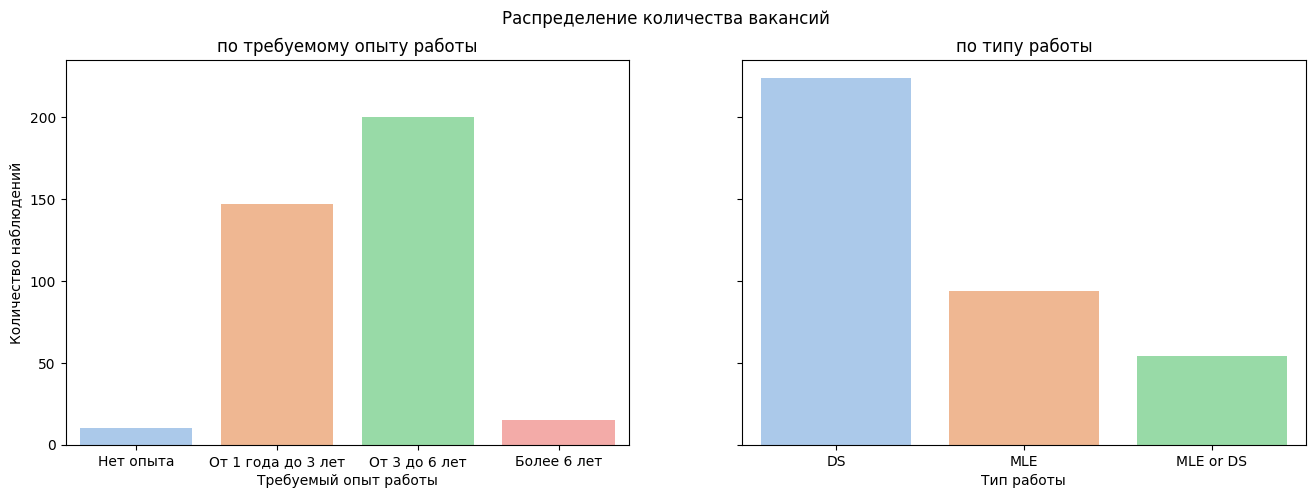

In [ ]:
category_order1 = ['Нет опыта', 'От 1 года до 3 лет', 'От 3 до 6 лет', 'Более 6 лет']
category_order2 = ['DS', 'MLE', 'MLE or DS']

fig, axes = plt.subplots(1, 2, figsize=(16,5), sharey=True)

sns.countplot(data=vacancies_df, x='experience.name', palette='pastel',
              ax=axes[0], order = category_order1)
sns.countplot(data=vacancies_df, x='job_type', palette='pastel',
              ax=axes[1], order = category_order2)

axes[0].set_title("по требуемому опыту работы")
axes[1].set_title("по типу работы")

axes[0].set_xlabel('Требуемый опыт работы')
axes[1].set_xlabel('Тип работы')

axes[0].set_ylabel('Количество наблюдений')
axes[1].set_ylabel('')

fig.suptitle('Распределение количества вакансий')
fig.show()

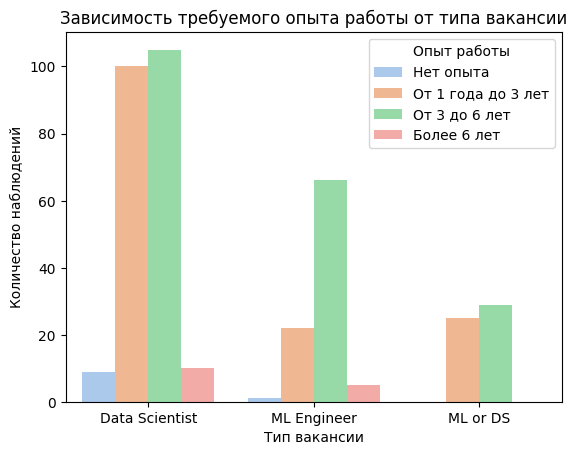

In [ ]:
# Посмотрим, как зависит требуемый опыт работы от типа вакансии

sns.countplot(data=vacancies_df, x='job_type', hue='experience.name',
              palette='pastel', order = category_order2,
              hue_order = category_order1)

plt.title('Зависимость требуемого опыта работы от типа вакансии')
plt.xlabel('Тип вакансии')
plt.xticks([0, 1, 2], ['Data Scientist', 'ML Engineer', 'ML or DS'])
plt.ylabel('Количество наблюдений')
plt.legend(title="Опыт работы")

plt.show()

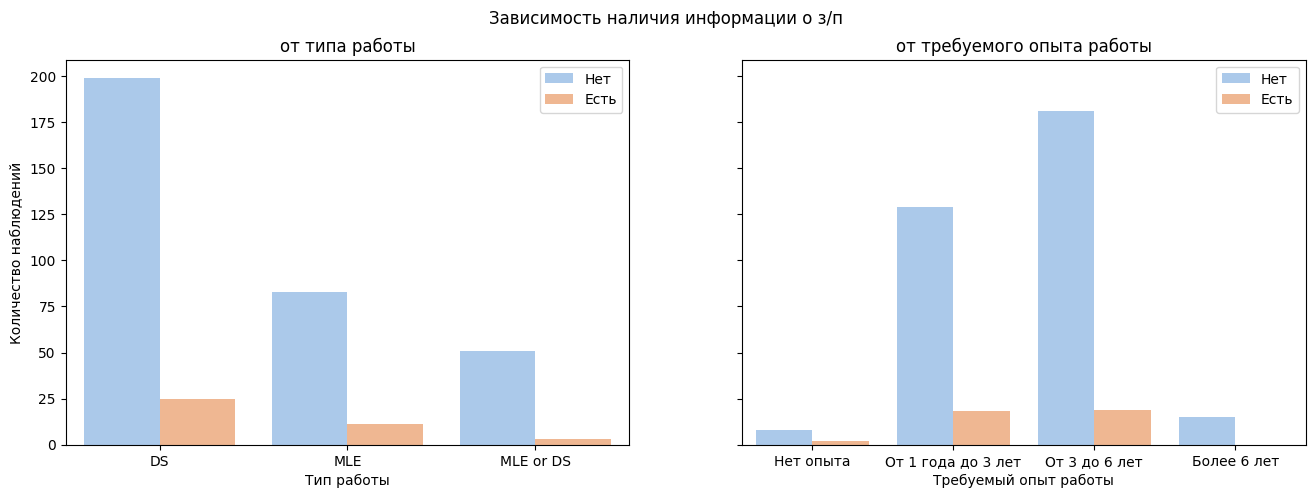

In [ ]:
# Посмотрим, как зависит наличие информации о з/п от типа работы

fig, axes = plt.subplots(1, 2, figsize=(16,5), sharey=True)

sns.countplot(data=vacancies_df, x='job_type', hue='salary_info',
              ax=axes[0], palette='pastel', order = category_order2)
sns.countplot(data=vacancies_df, x='experience.name', hue='salary_info',
              ax=axes[1], palette='pastel', order = category_order1)

axes[0].set_title("от типа работы")
axes[1].set_title("от требуемого опыта работы")

axes[0].set_xlabel('Тип работы')
axes[1].set_xlabel('Требуемый опыт работы')

axes[0].set_ylabel('Количество наблюдений')
axes[1].set_ylabel('')

axes[0].legend(labels=['Нет', 'Есть'])
axes[1].legend(labels=['Нет', 'Есть'])

fig.suptitle('Зависимость наличия информации о з/п')
fig.show()

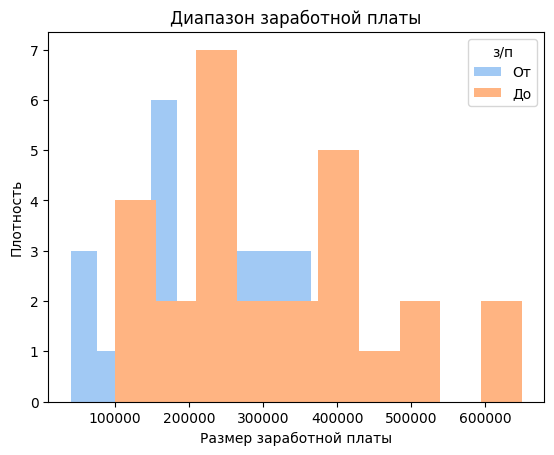

In [ ]:
plt.hist(vacancies_df["net_salary_from_rur"], color='#a1c9f4')
plt.hist(vacancies_df["net_salary_to_rur"], color='#ffb482')

plt.title("Диапазон заработной платы")
plt.ylabel('Плотность')
plt.xlabel('Размер заработной платы')
plt.legend(title="з/п", labels=['От','До'])
plt.show()

In [ ]:
vacancies_df[['intern', 'junior', 'middle', 'senior', 'lead']].describe()

,intern,junior,middle,senior,lead
count,372.000000,372.000000,372.000000,372.000000,372.000000
mean,0.018817,0.325269,0.666667,0.478495,0.120968
std,0.136062,0.469106,0.472039,0.500210,0.326529
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


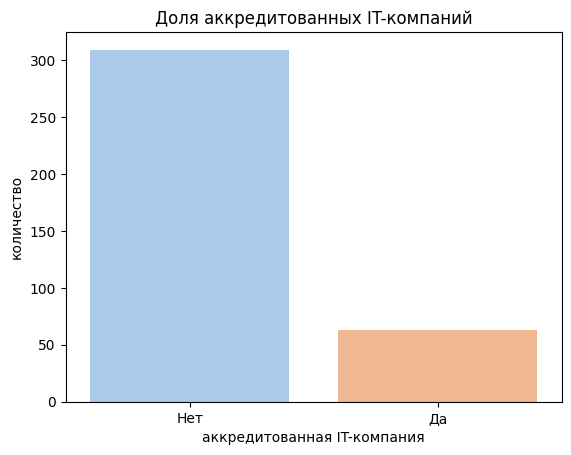

In [ ]:
sns.countplot(data=vacancies_df, x= 'employer.accredited_it_employer', palette='pastel')

plt.title("Доля аккредитованных IT-компаний")
plt.ylabel('количество')
plt.xlabel('аккредитованная IT-компания')
plt.xticks([0, 1], ['Нет', 'Да'])
plt.show()

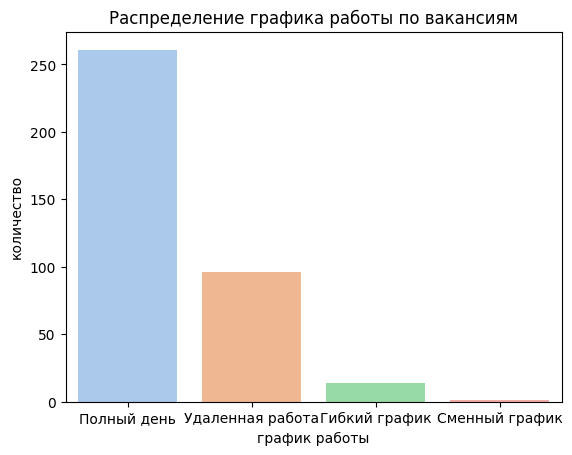

In [ ]:
sns.countplot(data=vacancies_df, x='schedule.name', palette='pastel')

plt.title("Распределение графика работы по вакансиям")
plt.ylabel('количество')
plt.xlabel('график работы')
plt.show()

In [ ]:
vacancies_df.to_csv('hh.csv', index=False)